## Aim of Study
The aim of this study is to evaluate and compare the performance of multiple classification algorithms in predicting customer churn, identifying which methods most accurately estimate churn risk based on available features.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import warnings
pd.set_option('display.expand_frame_repr', False)  # keep everything on one line
warnings.filterwarnings('ignore')

## Read in Data and EDA 

In [2]:
df = pd.read_csv("/Users/emudr/Desktop/data/BankCustomerChurnPrediction.csv")
print(df.describe())
print(df.info())
print(df.isna().sum())
print(df.duplicated().sum())
## No nulls, no duplicated, no outliers 

        customer_id  credit_score           age        tenure        balance  products_number  credit_card  active_member  estimated_salary         churn
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000     10000.000000  10000.00000   10000.000000      10000.000000  10000.000000
mean   1.569094e+07    650.528800     38.921800      5.012800   76485.889288         1.530200      0.70550       0.515100     100090.239881      0.203700
std    7.193619e+04     96.653299     10.487806      2.892174   62397.405202         0.581654      0.45584       0.499797      57510.492818      0.402769
min    1.556570e+07    350.000000     18.000000      0.000000       0.000000         1.000000      0.00000       0.000000         11.580000      0.000000
25%    1.562853e+07    584.000000     32.000000      3.000000       0.000000         1.000000      0.00000       0.000000      51002.110000      0.000000
50%    1.569074e+07    652.000000     37.000000      5.000000   97198.540000

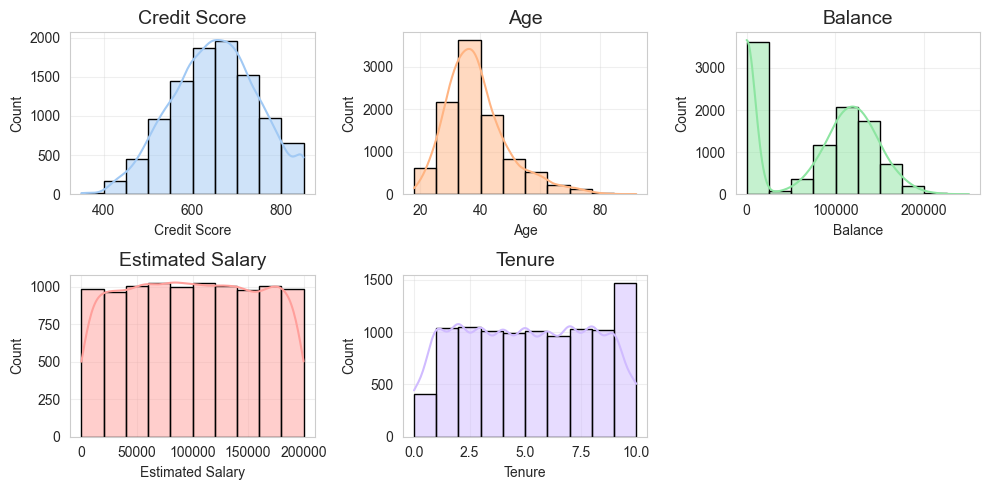

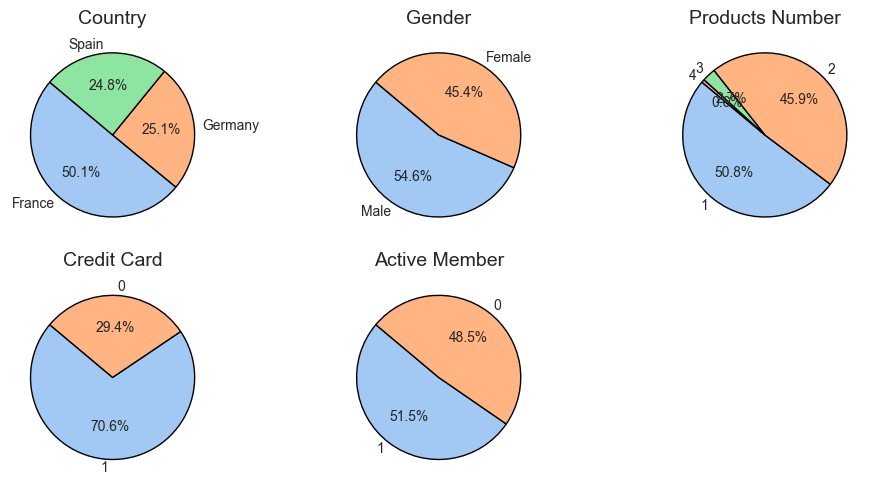

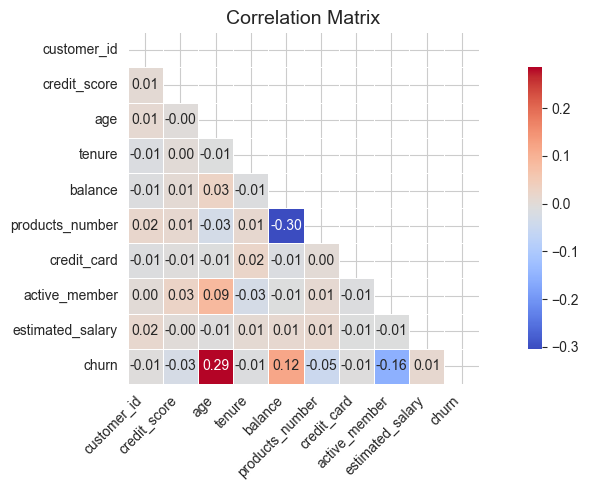

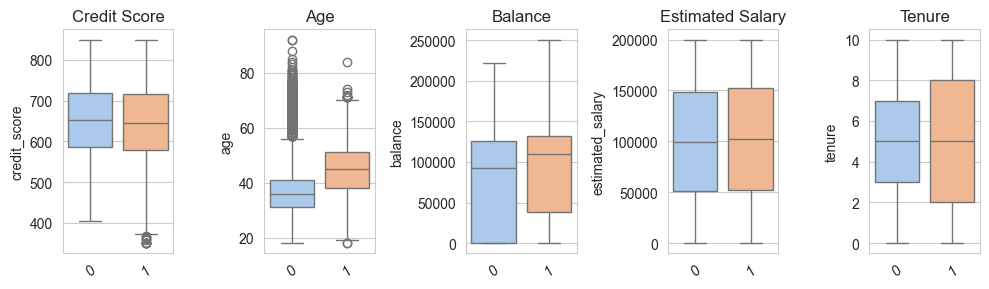

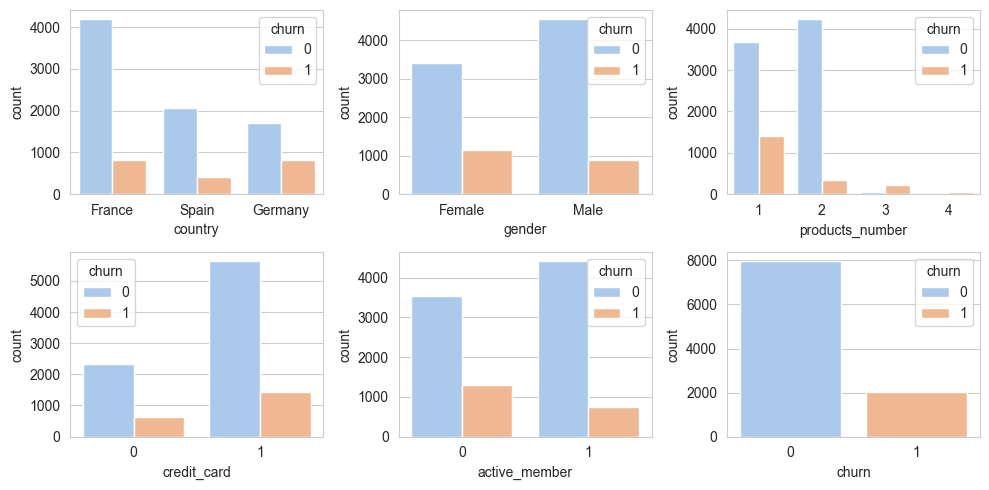

In [11]:
num_vars = ['credit_score', 'age', 'balance', 'estimated_salary', 'tenure']
cat_vars = ['country', 'gender', 'products_number', 'credit_card', 'active_member', 'churn']

def remove_unused_plots(num_vars, axs, fig):
    if len(num_vars) < len(axs):
        for j in range(len(num_vars), len(axs)):
            fig.delaxes(axs[j])
    return fig 
    


## Histplots
fig, axs = plt.subplots(2, 3, figsize=(10,5))
axs = axs.flatten()
colors = sns.color_palette("pastel")

for i, num_var in enumerate(num_vars):
    sns.histplot(df[num_var], kde=True, ax=axs[i], color=colors[i % len(colors)], edgecolor='k', bins=10)
    axs[i].set_title(num_var.replace('_',' ').title(), fontsize=14)
    axs[i].set_xlabel(num_var.replace('_',' ').title())
    axs[i].grid(True, alpha=0.3)

fig = remove_unused_plots(num_vars, axs, fig) 
plt.tight_layout()
plt.show()


## Pie plots
fig, axs = plt.subplots(2, 3, figsize=(10,5))
axs = axs.flatten()
colors = sns.color_palette("pastel")

for i, cat_var in enumerate(cat_vars):
    value_counts = df[cat_var].value_counts(dropna=False)
    wedges, texts, autotexts = axs[i].pie(
        value_counts, 
        labels=value_counts.index, 
        autopct='%1.1f%%', 
        colors=colors, 
        startangle=140, 
        wedgeprops={'edgecolor': 'k'}
    )
    axs[i].set_title(cat_var.replace('_',' ').title(), fontsize=14)

fig = remove_unused_plots(num_vars, axs, fig) 
plt.tight_layout()
plt.show()


## Correlation Matrix
plt.figure(figsize=(10,5))
corr = df.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    mask=mask, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8}, 
    square=True,
    annot_kws={"size":10}
)
plt.title("Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Boxplots
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,5, figsize=(10,3))
axs = axs.flatten()
for i, var in enumerate(num_vars):
    sns.boxplot(x='churn', y=var, data=df, ax=axs[i], palette='pastel')
    axs[i].set_title(var.replace('_', ' ').title(), fontsize=12)
    axs[i].set_xlabel('')
    axs[i].set_ylabel(var, fontsize=10)
    axs[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()


sns.set_style("whitegrid")
fig, axs = plt.subplots(2,3, figsize=(10,5))
axs = axs.flatten()
for i, var in enumerate(cat_vars):
    sns.countplot(x=var ,hue = 'churn', data=df, ax = axs[i], palette='pastel')  
plt.tight_layout()
plt.show()

##

## Preprocessing

In [12]:
num_vars = ['credit_score', 'age', 'balance', 'estimated_salary', 'tenure']
cat_vars = ['country', 'gender', 'products_number', 'credit_card', 'active_member']

# Assign X and y
features = num_vars + cat_vars

X = df[features]
y = df['churn']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for Logistic Regression, Naive Bayes, and SVMs - scale numeric variables, encode categorical vars
preprocessor1 = ColumnTransformer(transformers=[('num', StandardScaler(), num_vars), ('cat', OneHotEncoder(drop='first'), cat_vars)])
X_train_scaled_encoded = preprocessor1.fit_transform(X_train)
X_test_scaled_encoded = preprocessor1.transform(X_test)


# Preprocessing for Decision Trees, Random Forests, Boosting - only encode categorical vars (no scaling needed)
preprocessor2 = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars)], remainder="passthrough")   # keep numeric as-is
X_train_encoded = preprocessor2.fit_transform(X_train)
X_test_encoded = preprocessor2.transform(X_test)

## Model Building

In [16]:
## Logistic Regression
model = LogisticRegression(random_state=42) 
model.fit(X_train_scaled_encoded, y_train)
y_pred = model.predict(X_test_scaled_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy Logistic Regression : {accuracy}")


## Naive Bayes (Guassian)
model = GaussianNB()
model.fit(X_train_scaled_encoded, y_train)
y_pred = model.predict(X_test_scaled_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy Naive Bayes: {accuracy}")


## SVM
model = SVC(C=1, random_state = 42, kernel = 'rbf', probability = True)
model.fit(X_train_scaled_encoded, y_train)
y_pred = model.predict(X_test_scaled_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy SVM: {accuracy}")


## Decision Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy Decision Trees:, {accuracy}")


## Random Forests
model = RandomForestClassifier(random_state = 42)
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy Random Forests:, {accuracy}")


## Boosting
model = GradientBoostingClassifier(random_state = 42)
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy Gradient Boosting:, {accuracy}")


## XGBoost
model  = XGBClassifier(random_state=42, eval_metric="logloss")
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy XGBoost:, {accuracy}")


## ADA boost
model = AdaBoostClassifier(random_state = 42)
model  = XGBClassifier(random_state=42, eval_metric="logloss")
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy ADABoost:, {accuracy}")


Model Accuracy Logistic Regression : 0.843
Model Accuracy Naive Bayes: 0.8235
Model Accuracy SVM: 0.8605
Model Accuracy Decision Trees:, 0.783
Model Accuracy Random Forests:, 0.8715
Model Accuracy Gradient Boosting:, 0.8635
Model Accuracy XGBoost:, 0.863
Model Accuracy ADABoost:, 0.863


## Conclusion
Among the models evaluated for predicting customer churn, ensemble methods such as Random Forests (0.872) and boosting algorithms (Gradient Boosting, XGBoost, AdaBoost ~0.863) achieved the highest accuracy, outperforming single-model approaches like Logistic Regression (0.843), Naive Bayes (0.824), SVM (0.861), and Decision Trees (0.783). These results suggest that ensemble and boosting techniques provide the most reliable estimates of churn in this dataset.

## Choose best parameters 

In [5]:
# Define parameter grid for GridSearchCV
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

# Grid search with 5-fold CV
grid_search = GridSearchCV(SVC(),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Fit
grid_search.fit(X_train_encoded, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)


KeyboardInterrupt: 